In [25]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os
from numpy.lib.recfunctions import append_fields
import scipy.stats

import matplotlib.pyplot as plt
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap


input_path = '/users/PCON0003/warner785/DMASSy3/systematics/pca_SP107_SPT_v2_cformat/'
#y3/band_z/
keyword_template = 'pc{0}_'

chi2_randoms = []
chi2_dmassi = []
chi2_trend1 = []
chi2_trend2 = []
chi2_dmassf = []
trend = []

for i_pca in range(1): #50
    if i_pca > -1:
        input_keyword = keyword_template.format(i_pca)
        print(input_keyword)
        sysMap = io.SearchAndCallFits(path = input_path, keyword = input_keyword)

pc0_

Calling catalogs >>>
pc0_SP107_SPT_v2_cformat_4096ring.fits.gz
reading 1/1 /users/PCON0003/warner785/DMASSy3/systematics/pca_SP107_SPT_v2_cformat/pc0_SP107_SPT_v2_cformat_4096ring.fits.gz


In [26]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0008/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

def cutPCA(sysMap):
    
    RA, DEC = hp.pix2ang(4096, sysMap['PIXEL'], lonlat=True)
    sysMap = append_fields(sysMap, 'RA', RA, usemask=False)
    sysMap = append_fields(sysMap, 'DEC', DEC, usemask=False)
    #print(sysMap.dtype.names)

    sysMap = keepGoodRegion(sysMap)
    
    # for SPT region
    mask_spt = (sysMap['RA']>295)&(sysMap['RA']<360)|(sysMap['RA']<105)
    mask_spt = mask_spt & (sysMap['DEC']>-68) & (sysMap['DEC']<-10)
    sysMap = sysMap[mask_spt]
    
    # for validation region
#    mask4 =(sysMap['RA']>18)&(sysMap['RA']<43)
#    mask4 = mask4 & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
#    sysMap = sysMap[mask4]
    
    # for training region
#    mask = (sysMap['RA']>310) & (sysMap['RA']<360)|(sysMap['RA']<7)
#    mask = mask & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
#    sysMap = sysMap[mask]
    
    return sysMap

#sysMap['PIXEL'] = hp.nest2ring(4096, sysMap['PIXEL'])
sysMap = cutPCA(sysMap)

In [27]:
print(sysMap[sysMap['SIGNAL']==0])

[]


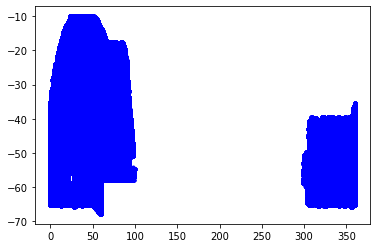

In [28]:
fig, ax = plt.subplots()
#ax.plot( dmass_chron['RA'], dmass_chron['DEC'], '.')
ax.plot( sysMap['RA'], sysMap['DEC'], "b.")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

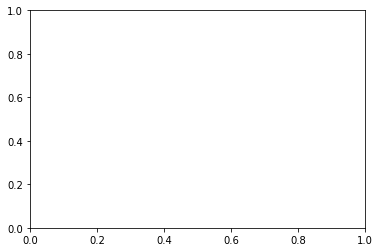

In [10]:
fig, ax = plt.subplots()
ax.plot( included['RA'], included['DEC'], '.')
ax.plot( sysMap['RA'], sysMap['DEC'], "b.")

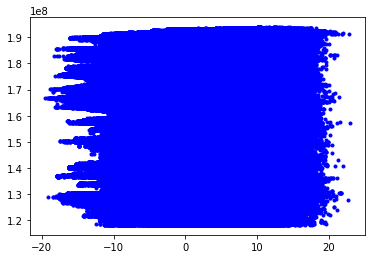

In [29]:
fig, ax = plt.subplots()
ax.plot( sysMap['SIGNAL'], sysMap['PIXEL'], "b.")

In [30]:
def calling_lens_catalog(catname=None):

    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
    os.system('mkdir '+catdir)
    dmass = esutil.io.read(catname)
    w_dmass = dmass['CMASS_PROB']
    print ('Calculating DMASS systematic weights...')
    dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
#   dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]   # for low probability galaxies
    esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')
    
    randoms = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/random_dmass_y1_public_v1.fits')
#    randoms = esutil.io.read('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200_randoms.fits')
    
#    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
#    os.system('mkdir '+catdir)
#    dmass = esutil.io.read('/n/des/lee.5922/data/dmass_cat/dmass_spt_sys_v3.fits')
    #w_dmass = dmass['CMASS_PROB'] *dmass['WEIGHT0_fwhm_r']*dmass['WEIGHT1_airmass_z']
    #print ('Calculatig DMASS systematic weights...')
    #dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
    #dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]
    #esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

#    randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

    print ('Resulting catalog size')
    print ('DMASS=', np.sum(dmass['WEIGHT']) )
    print ('randoms=', randoms.size)
    return dmass, randoms

In [31]:

dmass_spt, randoms = calling_lens_catalog('../output/test/train_cat/y3/dmass_spt.fits')

Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 351963.5197393462
randoms= 5864645


In [32]:
index_mask = np.argsort(dmass_spt)
dmass_chron = dmass_spt[index_mask]

In [33]:
print(dmass_chron.size)
print(sysMap.size)
included = np.in1d(sysMap["PIXEL"], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)
print(included.size)

dmass_sys = dmass_chron[included]

32409121
17201244
17201244


IndexError: boolean index did not match indexed array along dimension 0; dimension is 32409121 but corresponding boolean dimension is 17201244

In [38]:
input_path = '/fs/scratch/PCON0008/warner785/bwarner/PCA/band_g/' 
#/band_g,r,i,z/:

#test weighted pca-dmass on the sp checks

#y3a2_g_o.4096_t.32768_AIRMASS.WMEAN_EQU.fits.gz
#y3a2_g_o.4096_t.32768_EXPTIME.SUM_EQU.fits.gz 
#y3a2_g_o.4096_t.32768_FWHM.WMEAN_EQU.fits.gz 
#y3a2_g_o.4096_t.32768_SKYBRITE.WMEAN_EQU.fits.gz
#redmine
#nersc pca location for sp

#current_map = 'SKYBRITEz'

input_keyword = 'y3a2_g_o.4096_t.32768_EXPTIME.SUM_EQU.fits.gz'
Map = io.SearchAndCallFits(path = input_path, keyword = input_keyword)


Calling catalogs >>>
y3a2_g_o.4096_t.32768_EXPTIME.SUM_EQU.fits.gz
reading 1/1 /fs/scratch/PCON0008/warner785/bwarner/PCA/band_g/y3a2_g_o.4096_t.32768_EXPTIME.SUM_EQU.fits.gz


In [39]:
Map['PIXEL'] = hp.nest2ring(4096, Map['PIXEL'])
Map = cutPCA(Map)

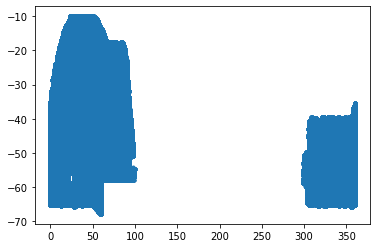

In [40]:
fig, ax = plt.subplots()
ax.plot( Map['RA'], Map['DEC'], '.')